In [1]:
# À mettre dans la toute première cellule du notebook
import os

# Désactiver complètement le GPU pour ce notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("GPU désactivé via CUDA_VISIBLE_DEVICES")


GPU désactivé via CUDA_VISIBLE_DEVICES


In [2]:
# ===============================
# 0. Imports & configuration
# ===============================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

# Désactiver complètement le GPU pour ce notebook
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices([], 'GPU')
        print("GPU désactivé, exécution forcée sur CPU.")
    except RuntimeError as e:
        print("Impossible de modifier les devices après initialisation :", e)

print("Devices visibles :", tf.config.get_visible_devices())

from tensorflow.keras import layers, models
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# Pour la reproductibilité
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Chemins dataset Flipkart
CSV_PATH = "../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
IMAGE_DIR = "../data/Flipkart/Images"

# Paramètres images & training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30


2026-01-02 10:39:13.376979: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 10:39:13.388009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767346753.400027   17388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767346753.403606   17388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-02 10:39:13.416610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Devices visibles : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow: 2.18.0
GPU: []


2026-01-02 10:39:14.453177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
# ===============================
# 1. Chargement des données Flipkart
# ===============================
df = pd.read_csv(CSV_PATH)
df.head()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
# ===============================
# 2. Extraction de la catégorie principale & chemins d'images
# ===============================
def extract_main_category(tree_str):
    if pd.isna(tree_str):
        return np.nan
    s = str(tree_str).strip("[]'\" ")
    first_segment = s.split(">>")[0]
    return first_segment.strip()

df["category"] = df["product_category_tree"].apply(extract_main_category)

def build_image_path(img_filename):
    if pd.isna(img_filename):
        return np.nan
    return os.path.join(IMAGE_DIR, str(img_filename))

df["image_path"] = df["image"].apply(build_image_path)

# On garde uniquement les lignes avec image et catégorie
df_img = df.dropna(subset=["category", "image_path"]).reset_index(drop=True)
print("Nb d'images utilisables :", len(df_img))
df_img[["category", "image_path"]].head()


Nb d'images utilisables : 1050


,category,image_path
0,Home Furnishing,../data/Flipkart/Images/55b85ea15a1536d46b7190...
1,Baby Care,../data/Flipkart/Images/7b72c92c2f6c40268628ec...
2,Baby Care,../data/Flipkart/Images/64d5d4a258243731dc7bbb...
3,Home Furnishing,../data/Flipkart/Images/d4684dcdc759dd9cdf4150...
4,Home Furnishing,../data/Flipkart/Images/6325b6870c54cd47be6ebf...


In [5]:
# ===============================
# 3. Équilibrage simple (optionnel)
#    On limite à N produits par catégorie pour éviter un déséquilibre massif
# ===============================
N_PER_CLASS = 150  # adapte si besoin en fonction du dataset

balanced_df_list = []
for cat, group in df_img.groupby("category"):
    if len(group) > N_PER_CLASS:
        balanced_df_list.append(group.sample(N_PER_CLASS, random_state=RANDOM_STATE))
    else:
        balanced_df_list.append(group)

df_balanced = pd.concat(balanced_df_list).reset_index(drop=True)
print("Shape après équilibrage :", df_balanced.shape)
df_balanced["category"].value_counts()


Shape après équilibrage : (1050, 17)


category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: count, dtype: int64

In [6]:
# ===============================
# 4. Encodage des labels (int)
# ===============================
class_names = sorted(df_balanced["category"].unique())
num_classes = len(class_names)
print("Nombre de classes :", num_classes)
print("Classes :", class_names)

# Dictionnaire catégorie -> index
class_to_idx = {c: i for i, c in enumerate(class_names)}
df_balanced["label_idx"] = df_balanced["category"].map(class_to_idx)

df_balanced[["category", "label_idx"]].head()


Nombre de classes : 7
Classes : ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


,category,label_idx
0,Baby Care,0
1,Baby Care,0
2,Baby Care,0
3,Baby Care,0
4,Baby Care,0


In [7]:
# ===============================
# 5. Split train / val / test (stratifié)
# ===============================
X = df_balanced["image_path"].values
y = df_balanced["label_idx"].values

# d'abord train+temp vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# puis train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_trainval
)

len(X_train), len(X_val), len(X_test)


(672, 168, 210)

In [8]:
# ===============================
# 6. Datasets tf.data à partir des chemins d'images
# ===============================

def decode_and_resize(path, label_idx):
    """
    lit le fichier image, le décode, le redimensionne,
    et applique le preprocess_input de MobileNetV2.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    
    img = mobilenet_v2.preprocess_input(img)  # [-1, 1]
    
    # one-hot pour la classification multi-classes
    label = tf.one_hot(label_idx, depth=num_classes)
    return img, label

def make_dataset(paths, labels, batch_size, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_STATE)
    ds = ds.map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val,   y_val,   BATCH_SIZE, shuffle=False)
test_ds  = make_dataset(X_test,  y_test,  BATCH_SIZE, shuffle=False)


In [9]:
# ===============================
# 7. Data augmentation (dans le modèle)
# ===============================
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)


In [10]:
# ===============================
# 8. Modèle CNN pré-entraîné (MobileNetV2)
# ===============================
base_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg"  # vecteur global de features
)

# On fige les poids du backbone pour une première phase
base_model.trainable = False

base_model.summary(line_length=120, show_trainable=True)


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━
┃ Layer (type)                  ┃ Output Shape              ┃          Param # ┃ Connected to              ┃ Traina
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │                0 │ -                         │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │              864 │ input_layer[0][0]         │     N 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │              128 │ Conv1[0][0]               │     N 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │                0 │ bn_Conv1[0][0]            │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │              288 │ Conv1_relu[0][0]          │     N 
│ (DepthwiseConv2D)             │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │              128 │ expanded_conv_depthwise[… │     N 
│ (BatchNormalization)          │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │                0 │ expanded_conv_depthwise_… │     - 
│ (ReLU)                        │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ expanded_conv_project         │ (None, 112, 112, 16)      │              512 │ expanded_conv_depthwise_… │     N 
│ (Conv2D)                      │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │               64 │ expanded_conv_project[0]… │     N 
│ (BatchNormalization)          │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │            1,536 │ expanded_conv_project_BN… │     N 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ block_1_expand_BN             │ (None, 112, 112, 96)      │              384 │ block_1_expand[0][0]      │     N 
│ (BatchNormalization)          │                           │                  │                           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │                0 │ block_1_expand_BN[0][0]   │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │                0 │ block_1_expand_relu[0][0] │     - 
├───────────────────────────────┼───────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# ===============================
# 9. Construction du modèle complet (augmentation + backbone + tête)
# ===============================
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = data_augmentation(inputs)                  # data augmentation
x = base_model(x, training=False)              # backbone gelé
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="mobilenetv2_transfer_learning")

model.summary(line_length=120)


Model: "mobilenetv2_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 224, 224, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 224, 224, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ mobilenetv2_1.00_224 (Functional)                   │ (None, 1280)                           │             2,257,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 256)                            │               327,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_1 (Dropout)                                 │ (None, 256)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_1 (Dense)                                     │ (None, 7)                              │                 1,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# ===============================
# 10. Compilation du modèle + callbacks
# ===============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "best_cnn_flipkart.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False
    ),
]


In [13]:
# ===============================
# 11. Entraînement supervisé
# ===============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1700 - loss: 2.3165

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.1860 - loss: 2.2148 - val_accuracy: 0.4226 - val_loss: 1.5367 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3906 - loss: 1.7512

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.4315 - loss: 1.6398 - val_accuracy: 0.6905 - val_loss: 1.2110 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5275 - loss: 1.4120

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.5417 - loss: 1.3422 - val_accuracy: 0.7381 - val_loss: 0.9781 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6423 - loss: 1.1392

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6473 - loss: 1.1048 - val_accuracy: 0.7857 - val_loss: 0.8355 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6293 - loss: 1.0852

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.6577 - loss: 1.0262 - val_accuracy: 0.7917 - val_loss: 0.7463 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7310 - loss: 0.8903

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.7307 - loss: 0.8717 - val_accuracy: 0.8036 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7634 - loss: 0.8137

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7515 - loss: 0.7979 - val_accuracy: 0.8155 - val_loss: 0.6427 - learning_rate: 1.0000e-04
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7312 - loss: 0.8315

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.7426 - loss: 0.7895 - val_accuracy: 0.8274 - val_loss: 0.6247 - learning_rate: 1.0000e-04
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7508 - loss: 0.7254

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7693 - loss: 0.7037 - val_accuracy: 0.8155 - val_loss: 0.5929 - learning_rate: 1.0000e-04
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7402 - loss: 0.7153

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7649 - loss: 0.6884 - val_accuracy: 0.8274 - val_loss: 0.5840 - learning_rate: 1.0000e-04
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7809 - loss: 0.6665

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7887 - loss: 0.6524 - val_accuracy: 0.8333 - val_loss: 0.5691 - learning_rate: 1.0000e-04
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8105 - loss: 0.5963

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7976 - loss: 0.6000 - val_accuracy: 0.8333 - val_loss: 0.5563 - learning_rate: 1.0000e-04
Epoch 13/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8280 - loss: 0.5584

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7991 - loss: 0.5999 - val_accuracy: 0.8214 - val_loss: 0.5528 - learning_rate: 1.0000e-04
Epoch 14/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8305 - loss: 0.5273

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.8140 - loss: 0.5672 - val_accuracy: 0.8333 - val_loss: 0.5511 - learning_rate: 1.0000e-04
Epoch 15/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8274 - loss: 0.5443 - val_accuracy: 0.8333 - val_loss: 0.5516 - learning_rate: 1.0000e-04
Epoch 16/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8368 - loss: 0.5003

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.8363 - loss: 0.5115 - val_accuracy: 0.8214 - val_loss: 0.5452 - learning_rate: 1.0000e-04
Epoch 17/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8261 - loss: 0.5017

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.8199 - loss: 0.5415 - val_accuracy: 0.8274 - val_loss: 0.5387 - learning_rate: 1.0000e-04
Epoch 18/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.8482 - loss: 0.4823 - val_accuracy: 0.8333 - val_loss: 0.5421 - learning_rate: 1.0000e-04
Epoch 19/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8652 - loss: 0.4289

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.8497 - loss: 0.4284 - val_accuracy: 0.8274 - val_loss: 0.5374 - learning_rate: 1.0000e-04
Epoch 20/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8393 - loss: 0.4656 - val_accuracy: 0.8214 - val_loss: 0.5405 - learning_rate: 1.0000e-04
Epoch 21/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8539 - loss: 0.4569

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.8452 - loss: 0.4728 - val_accuracy: 0.8155 - val_loss: 0.5362 - learning_rate: 1.0000e-04
Epoch 22/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8431 - loss: 0.4300

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.8467 - loss: 0.4248 - val_accuracy: 0.8155 - val_loss: 0.5302 - learning_rate: 1.0000e-04
Epoch 23/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.8527 - loss: 0.4195 - val_accuracy: 0.8333 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 24/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8771 - loss: 0.3949

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.8631 - loss: 0.4170 - val_accuracy: 0.8333 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 25/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.8586 - loss: 0.4059 - val_accuracy: 0.8214 - val_loss: 0.5277 - learning_rate: 1.0000e-04
Epoch 26/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.8795 - loss: 0.3760 - val_accuracy: 0.8274 - val_loss: 0.5308 - learning_rate: 1.0000e-04
Epoch 27/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8899 - loss: 0.3515 - val_accuracy: 0.8214 - val_loss: 0.5278 - learning_rate: 5.0000e-05
Epoch 28/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.8884 - loss: 0.3538 - val_accuracy: 0.8214 - val_loss: 0.5282 - learning_rate: 5.0000e-05
Epoch 29/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.8780 - loss: 0.3503 - val_accuracy: 0.8274 - val_loss: 0.5282 - learning_rate: 2.5000e-05


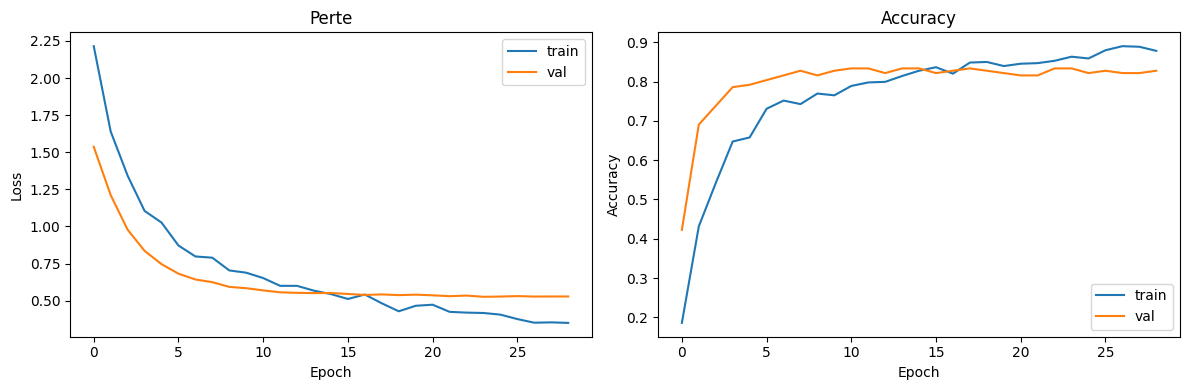

In [14]:
# ===============================
# 12. Courbes perte / accuracy
# ===============================
hist = history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Perte")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"], label="train")
plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# ===============================
# 13. Évaluation sur le set de test
# ===============================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test loss : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")


Test loss : 0.5598
Test accuracy : 0.8190
